📌 1. Load Both Datasets

In [2]:
import pandas as pd

df_ew = pd.read_csv('../data/EW-Passenger flow-station-hour.csv')
df_ns = pd.read_csv('../data/NS-Passenger flow-station-hour.csv')


📌 2. Preprocess: Add Total Flow Column to Each

In [3]:
df_ew['TotalFlow'] = df_ew.iloc[:, 1:].sum(axis=1)
df_ns['TotalFlow'] = df_ns.iloc[:, 1:].sum(axis=1)


📌 3. Visual: Total Flow per Station

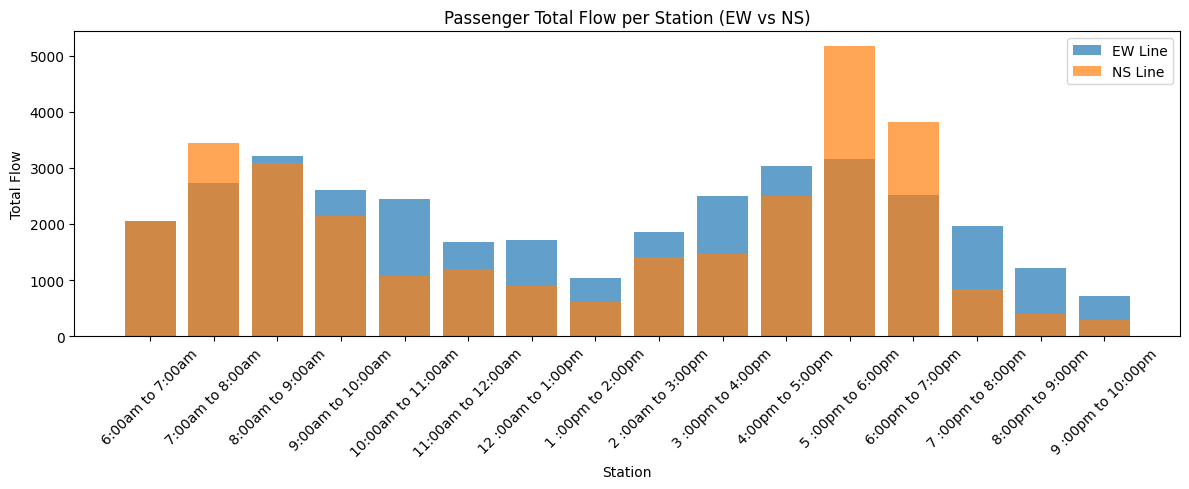

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(df_ew['Station'], df_ew['TotalFlow'], label='EW Line', alpha=0.7)
plt.bar(df_ns['Station'], df_ns['TotalFlow'], label='NS Line', alpha=0.7)
plt.title("Passenger Total Flow per Station (EW vs NS)")
plt.xlabel("Station")
plt.ylabel("Total Flow")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


📌 4. Visual: Average Passenger Flow per EW/NS Code

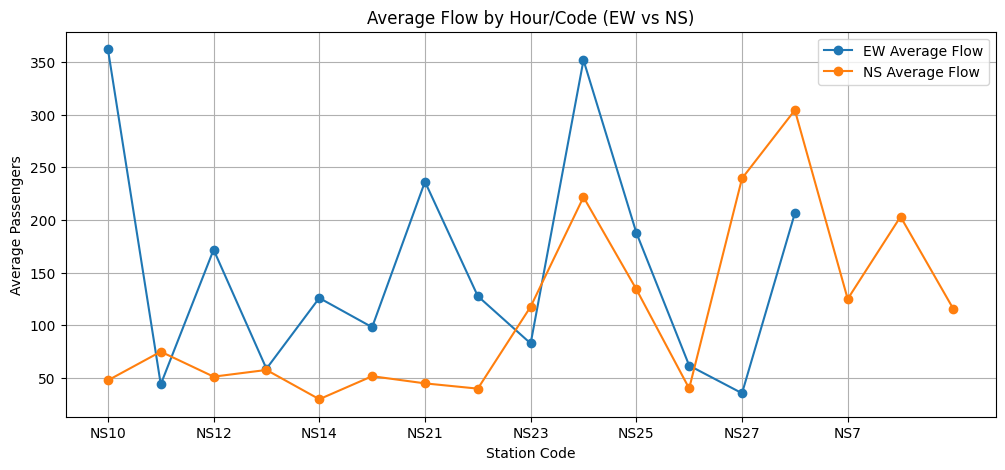

In [5]:
ew_cols = df_ew.columns[1:-1]
ns_cols = df_ns.columns[1:-1]

avg_ew = df_ew[ew_cols].mean().sort_index()
avg_ns = df_ns[ns_cols].mean().sort_index()

plt.figure(figsize=(12,5))
avg_ew.plot(kind='line', label='EW Average Flow', marker='o')
avg_ns.plot(kind='line', label='NS Average Flow', marker='o')
plt.title("Average Flow by Hour/Code (EW vs NS)")
plt.ylabel("Average Passengers")
plt.xlabel("Station Code")
plt.legend()
plt.grid()
plt.show()


📌 5. Correlation Heatmaps (Separately)

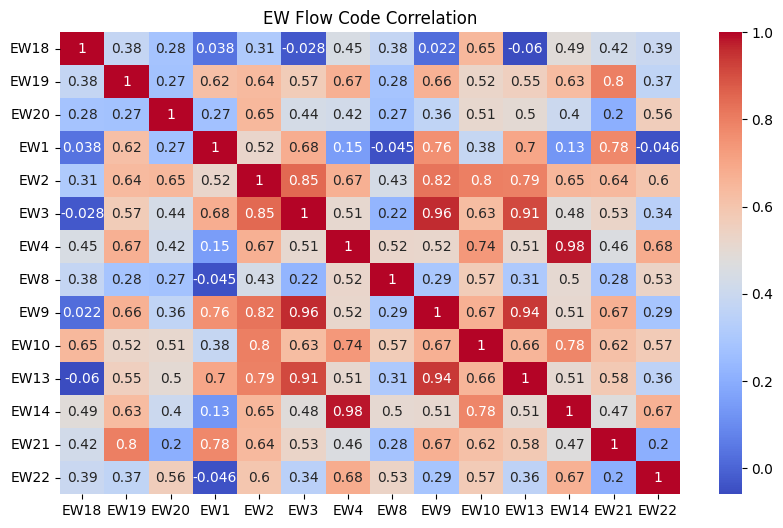

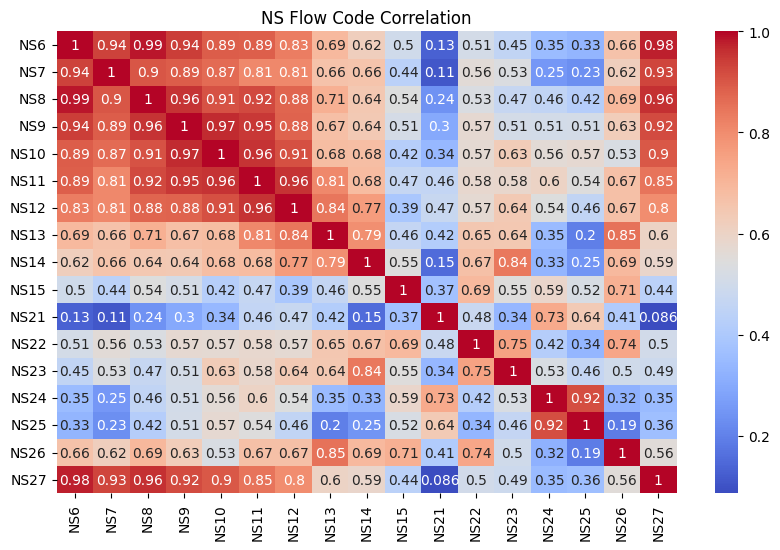

In [6]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df_ew[ew_cols].corr(), cmap='coolwarm', annot=True)
plt.title("EW Flow Code Correlation")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df_ns[ns_cols].corr(), cmap='coolwarm', annot=True)
plt.title("NS Flow Code Correlation")
plt.show()


📌 6. Clustering: Combine & Compare Station Types

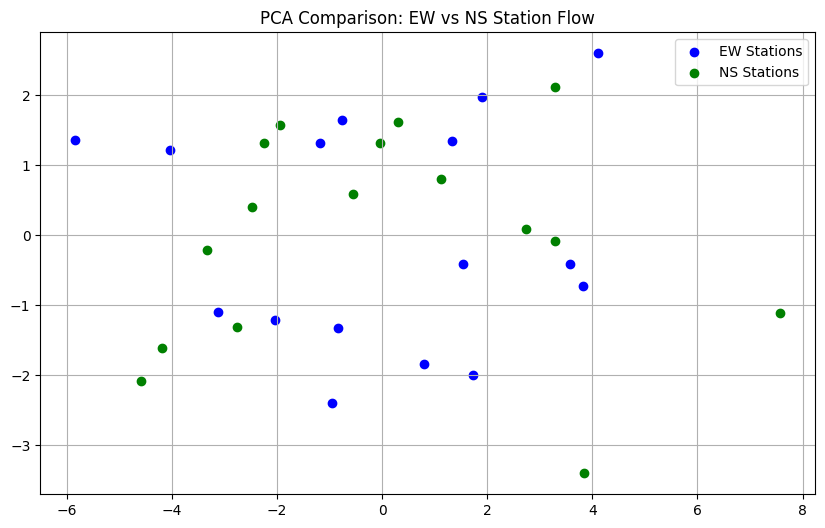

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Standardize separately
X_ew = StandardScaler().fit_transform(df_ew.iloc[:,1:-1])
X_ns = StandardScaler().fit_transform(df_ns.iloc[:,1:-1])

# PCA
pca = PCA(n_components=2)
ew_pca = pca.fit_transform(X_ew)
ns_pca = pca.fit_transform(X_ns)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(ew_pca[:,0], ew_pca[:,1], c='blue', label='EW Stations')
plt.scatter(ns_pca[:,0], ns_pca[:,1], c='green', label='NS Stations')
plt.title("PCA Comparison: EW vs NS Station Flow")
plt.legend()
plt.grid()
plt.show()


📌 Top 3 Busiest Stations per Line

In [8]:
top3_ew = df_ew.sort_values('TotalFlow', ascending=False).head(3)[['Station', 'TotalFlow']]
top3_ns = df_ns.sort_values('TotalFlow', ascending=False).head(3)[['Station', 'TotalFlow']]

print("Top 3 busiest EW stations:")
print(top3_ew)

print("\nTop 3 busiest NS stations:")
print(top3_ns)


Top 3 busiest EW stations:
              Station  TotalFlow
2    8:00am to 9:00am       3211
11  5 :00pm to 6:00pm       3150
10   4:00pm to 5:00pm       3030

Top 3 busiest NS stations:
              Station  TotalFlow
11  5 :00pm to 6:00pm       5174
12   6:00pm to 7:00pm       3823
1    7:00am to 8:00am       3443


📌 Average Flow Difference Between Lines

In [9]:
avg_diff = df_ew['TotalFlow'].mean() - df_ns['TotalFlow'].mean()
print(f"\nAverage flow difference (EW - NS): {avg_diff:.2f} passengers")



Average flow difference (EW - NS): 252.81 passengers


📌 Variance of Usage per Code

In [10]:
variance_ew = df_ew.drop(columns=['Station', 'TotalFlow']).var().sort_values(ascending=False)
variance_ns = df_ns.drop(columns=['Station', 'TotalFlow']).var().sort_values(ascending=False)

print("\nEW sensor code variances:")
print(variance_ew)

print("\nNS sensor code variances:")
print(variance_ns)



EW sensor code variances:
EW22    23473.662500
EW1     21116.066667
EW2     12735.983333
EW3     10094.995833
EW13     7924.866667
EW9      7838.262500
EW18     5854.250000
EW20     5048.383333
EW19     3000.250000
EW21     2659.162500
EW14      847.695833
EW4       822.895833
EW10      364.695833
EW8       216.116667
dtype: float64

NS sensor code variances:
NS6     104266.383333
NS27     64702.133333
NS8      47897.716667
NS7      14754.995833
NS24     11802.333333
NS9      11681.862500
NS25      8318.029167
NS11      3770.250000
NS23      3625.450000
NS13      2991.066667
NS12      2092.783333
NS10      1684.783333
NS15      1078.262500
NS26      1066.062500
NS21       795.666667
NS14       619.162500
NS22       503.400000
dtype: float64


📌 Clustering to See Similar Station Behavior

In [11]:
# Normalize the flow features
ew_scaled = StandardScaler().fit_transform(df_ew.drop(columns=['Station', 'TotalFlow']))
ns_scaled = StandardScaler().fit_transform(df_ns.drop(columns=['Station', 'TotalFlow']))

# Combine and label data
combined_scaled = pd.concat([
    pd.DataFrame(ew_scaled, index=df_ew['Station']),
    pd.DataFrame(ns_scaled, index=df_ns['Station'])
])
# Check for missing values
print(combined_scaled.isnull().sum())

# Option 1: Drop rows with NaNs
# combined_scaled_cleaned = combined_scaled.dropna()

# Option 2: Fill NaNs with the mean (or median)
combined_scaled_cleaned = combined_scaled.fillna(combined_scaled.mean())

# PCA for visualization (optional)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(combined_scaled)

# Add cluster labels
cluster_df = pd.DataFrame({
    'Station': combined_scaled.index,
    'Cluster': clusters,
    'Line': ['EW'] * len(df_ew) + ['NS'] * len(df_ns)
})

print("\nSample of station clusters:")
print(cluster_df.groupby(['Cluster', 'Line']).size().unstack(fill_value=0))


0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14    16
15    16
16    16
dtype: int64


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

📊 Summary Table

In [ ]:
summary = pd.DataFrame({
    'Metric': ['Total passengers', 'Mean per station', 'Max station', 'Std deviation'],
    'EW Line': [
        df_ew['TotalFlow'].sum(),
        df_ew['TotalFlow'].mean(),
        df_ew.loc[df_ew['TotalFlow'].idxmax(), 'Station'],
        df_ew['TotalFlow'].std()
    ],
    'NS Line': [
        df_ns['TotalFlow'].sum(),
        df_ns['TotalFlow'].mean(),
        df_ns.loc[df_ns['TotalFlow'].idxmax(), 'Station'],
        df_ns['TotalFlow'].std()
    ]
})

print("\n📊 Summary Table:")
print(summary)



📊 Summary Table:
             Metric           EW Line            NS Line
0  Total passengers             34409              30364
1  Mean per station         2150.5625            1897.75
2       Max station  8:00am to 9:00am  5 :00pm to 6:00pm
3     Std deviation        754.627234        1389.535534
